In [9]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

class RobustMFCCExtractor:
    """
    Enhanced MFCC feature extraction with multiple robust techniques
    """
    
    def __init__(self, sr=22050, n_mfcc=40, n_fft=2048, hop_length=512):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def extract_mfcc_features(self, audio_path, augment=False):
        """
        Extract comprehensive MFCC-based features
        """
        try:
            # Load audio with robust loading
            y, sr = librosa.load(audio_path, sr=self.sr, duration=4.0)
            
            # Zero-padding or truncation for consistent length
            target_length = self.sr * 4  # 4 seconds
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Apply pre-emphasis filter
            y = librosa.effects.preemphasis(y)
            
            # Extract base MFCCs
            mfccs = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                n_fft=self.n_fft,
                hop_length=self.hop_length
            )
            
            # Extract delta and delta-delta features
            mfcc_delta = librosa.feature.delta(mfccs)
            mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
            
            # Extract other complementary features
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=self.hop_length)
            tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=self.n_fft, hop_length=self.hop_length)
            
            # Root Mean Square Energy
            rms = librosa.feature.rms(y=y, hop_length=self.hop_length)
            
            # Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y, hop_length=self.hop_length)
            
            # Spectral Centroid and Rolloff
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=self.hop_length)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=self.hop_length)
            
            # Combine all features
            features = np.vstack([
                mfccs,
                mfcc_delta,
                mfcc_delta2,
                chroma,
                spectral_contrast,
                tonnetz,
                rms,
                zcr,
                spectral_centroid,
                spectral_rolloff
            ])
            
            # Extract statistical features
            feature_stats = self._extract_statistics(features)
            
            return feature_stats
            
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            return np.zeros(280)  # Return zero array with expected feature dimension
    
    def _extract_statistics(self, features):
        """
        Extract statistical features from feature matrix
        """
        stats = []
        for feature in features:
            stats.extend([
                np.mean(feature),
                np.std(feature),
                np.median(feature),
                np.min(feature),
                np.max(feature),
                np.percentile(feature, 25),
                np.percentile(feature, 75),
                np.mean(np.diff(feature)),  # Average change
                np.std(np.diff(feature))    # Std of changes
            ])
        return np.array(stats)
    
    def extract_log_mel_spectrogram(self, audio_path):
        """
        Alternative: Log-Mel Spectrogram features
        """
        y, sr = librosa.load(audio_path, sr=self.sr, duration=4.0)
        
        # Extract Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, 
            sr=sr, 
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=128
        )
        
        # Convert to log scale
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        
        return log_mel
    
    def extract_all_features(self, audio_paths, labels=None):
        """
        Extract features from multiple audio files
        """
        features = []
        valid_paths = []
        valid_labels = []
        
        for idx, path in enumerate(audio_paths):
            feat = self.extract_mfcc_features(path)
            if np.sum(feat) != 0:  # Skip zero features
                features.append(feat)
                valid_paths.append(path)
                if labels is not None:
                    valid_labels.append(labels[idx])
        
        features = np.array(features)
        
        # Normalize features
        if len(features) > 0:
            features = self.scaler.fit_transform(features)
        
        # Encode labels if provided
        if labels is not None and len(valid_labels) > 0:
            encoded_labels = self.label_encoder.fit_transform(valid_labels)
        else:
            encoded_labels = None
        
        return features, encoded_labels, valid_paths

In [10]:
import os
import glob
from tqdm import tqdm

class UrbanSound8KProcessor:
    """
    Process UrbanSound8K dataset
    """
    
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.metadata_path = os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv')
        self.metadata = pd.read_csv(self.metadata_path)
        
    def prepare_data(self, folds=None):
        """
        Prepare data for specific folds or all folds
        """
        if folds is None:
            folds = list(range(1, 11))
        elif isinstance(folds, int):
            folds = [folds]
        
        audio_paths = []
        labels = []
        fold_numbers = []
        
        for fold in folds:
            fold_data = self.metadata[self.metadata['fold'] == fold]
            
            for _, row in tqdm(fold_data.iterrows(), desc=f'Processing Fold {fold}'):
                audio_file = os.path.join(
                    self.dataset_path,
                    'fold' + str(row['fold']),
                    row['slice_file_name']
                )
                
                if os.path.exists(audio_file):
                    audio_paths.append(audio_file)
                    labels.append(row['class'])
                    fold_numbers.append(fold)
        
        return audio_paths, labels, fold_numbers
    
    def get_class_distribution(self):
        """
        Get class distribution statistics
        """
        return self.metadata['class'].value_counts()

In [17]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

class TraditionalMLClassifier:
    """
    Traditional machine learning classifiers
    """
    
    def __init__(self):
        self.models = {
            'random_forest': RandomForestClassifier(n_estimators=200, random_state=42),
            'svm': SVC(probability=True, random_state=42),
            'xgboost': XGBClassifier(n_estimators=200, random_state=42),
            'gradient_boosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
        }
        
    def train(self, X_train, y_train):
        """
        Train all models
        """
        trained_models = {}
        
        for name, model in self.models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            trained_models[name] = model
            
        return trained_models
    
    def evaluate(self, models, X_test, y_test):
        """
        Evaluate all models
        """
        results = {}
        
        for name, model in models.items():
            accuracy = model.score(X_test, y_test)
            results[name] = accuracy
            print(f"{name} Accuracy: {accuracy:.4f}")
            
        return results

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class CNNClassifier:
    """
    CNN-based classifier for audio features
    """
    
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()
        
    def _build_model(self):
        """
        Build CNN model architecture
        """
        model = models.Sequential([
            # Reshape for CNN input
            layers.Reshape((self.input_shape[0], self.input_shape[1], 1), 
                          input_shape=self.input_shape),
            
            # First Conv Block
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Second Conv Block
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Third Conv Block
            layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Global Pooling and Dense Layers
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            # Output layer
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """
        Train CNN model
        """
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        return history

In [20]:
def main():
    # Initialize paths
    DATASET_PATH = "UrbanSound8K/"  # Update this path
    OUTPUT_PATH = "results"
    
    # Create output directory
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    
    # Step 1: Process data
    print("Step 1: Processing UrbanSound8K dataset...")
    processor = UrbanSound8KProcessor(DATASET_PATH)
    
    # Prepare data for folds 1-8 for training, 9-10 for testing
    train_folds = list(range(1, 9))
    test_folds = [9, 10]
    
    train_paths, train_labels, _ = processor.prepare_data(train_folds)
    test_paths, test_labels, _ = processor.prepare_data(test_folds)
    
    print(f"Training samples: {len(train_paths)}")
    print(f"Testing samples: {len(test_paths)}")
    
    # Step 2: Extract features
    print("\nStep 2: Extracting features...")
    extractor = RobustMFCCExtractor()
    
    X_train, y_train, _ = extractor.extract_all_features(train_paths, train_labels)
    X_test, y_test, _ = extractor.extract_all_features(test_paths, test_labels)
    
    print(f"Feature shape - Train: {X_train.shape}, Test: {X_test.shape}")
    
    # Step 3: Train traditional models
    print("\nStep 3: Training traditional ML models...")
    ml_classifier = TraditionalMLClassifier()
    trained_models = ml_classifier.train(X_train, y_train)
    
    # Step 4: Evaluate models
    print("\nStep 4: Evaluating models...")
    results = ml_classifier.evaluate(trained_models, X_test, y_test)
    
    # Step 5: For CNN - reshape features for 2D input
    print("\nStep 5: Training CNN model...")
    
    # Reshape features to 2D (assuming we use log-mel spectrograms)
    X_train_cnn = []
    X_test_cnn = []
    
    for path in tqdm(train_paths, desc="Extracting CNN features for train"):
        log_mel = extractor.extract_log_mel_spectrogram(path)
        X_train_cnn.append(log_mel)
    
    for path in tqdm(test_paths, desc="Extracting CNN features for test"):
        log_mel = extractor.extract_log_mel_spectrogram(path)
        X_test_cnn.append(log_mel)
    
    X_train_cnn = np.array(X_train_cnn)
    X_test_cnn = np.array(X_test_cnn)
    
    # Encode labels for CNN
    label_encoder = LabelEncoder()
    y_train_cnn = label_encoder.fit_transform(train_labels)
    y_test_cnn = label_encoder.transform(test_labels)
    
    # Build and train CNN
    cnn_classifier = CNNClassifier(
        input_shape=X_train_cnn[0].shape,
        num_classes=len(np.unique(y_train_cnn))
    )
    
    history = cnn_classifier.train(
        X_train_cnn, y_train_cnn,
        X_test_cnn, y_test_cnn,
        epochs=50,
        batch_size=32
    )
    
    # Evaluate CNN
    cnn_test_loss, cnn_test_acc = cnn_classifier.model.evaluate(X_test_cnn, y_test_cnn)
    print(f"\nCNN Test Accuracy: {cnn_test_acc:.4f}")
    
    # Step 6: Save results
    results_df = pd.DataFrame({
        'Model': list(results.keys()) + ['CNN'],
        'Accuracy': list(results.values()) + [cnn_test_acc]
    })
    
    results_df.to_csv(os.path.join(OUTPUT_PATH, 'model_results.csv'), index=False)
    print("\nResults saved to 'results/model_results.csv'")

if __name__ == "__main__":
    main()

Step 1: Processing UrbanSound8K dataset...


Processing Fold 1: 873it [00:00, 17267.43it/s]
Processing Fold 2: 888it [00:00, 38398.13it/s]
Processing Fold 3: 925it [00:00, 9325.92it/s]
Processing Fold 4: 990it [00:00, 14548.66it/s]
Processing Fold 5: 936it [00:00, 14790.82it/s]
Processing Fold 6: 823it [00:00, 14524.70it/s]
Processing Fold 7: 838it [00:00, 13646.00it/s]
Processing Fold 8: 806it [00:00, 13961.67it/s]
Processing Fold 9: 816it [00:00, 14644.94it/s]
Processing Fold 10: 837it [00:00, 13699.44it/s]


Training samples: 0
Testing samples: 0

Step 2: Extracting features...
Feature shape - Train: (0,), Test: (0,)

Step 3: Training traditional ML models...
Training random_forest...


ValueError: This RandomForestClassifier estimator requires y to be passed, but the target y is None.

In [15]:
class AdvancedMFCCTechniques:
    """
    Advanced techniques for improved MFCC extraction
    """
    
    @staticmethod
    def apply_vtlp(audio, sr, alpha=0.9):
        """
        Vocal Tract Length Perturbation
        """
        # Implement VTLP warping
        n_fft = 2048
        mel_basis = librosa.filters.mel(sr, n_fft)
        warped_mel_basis = AdvancedMFCCTechniques._warp_mel_basis(mel_basis, alpha)
        
        # Apply warped mel basis
        stft = librosa.stft(audio, n_fft=n_fft)
        mel_spec = np.dot(warped_mel_basis, np.abs(stft))
        
        return librosa.power_to_db(mel_spec)
    
    @staticmethod
    def _warp_mel_basis(mel_basis, alpha):
        """
        Warp mel basis for VTLP
        """
        # Simplified warping - implement full VTLP for production
        return mel_basis
    
    @staticmethod
    def extract_mfcc_with_snr_weighting(audio, sr, snr_threshold=20):
        """
        Extract MFCCs with SNR-based weighting
        """
        # Calculate SNR
        signal_power = np.mean(audio**2)
        noise_power = np.mean((audio - np.mean(audio))**2)
        snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
        
        # Weight features based on SNR
        if snr < snr_threshold:
            # Apply noise reduction or use robust features
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            # Apply additional processing for noisy audio
            return mfccs * (snr / snr_threshold)
        else:
            return librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    
    @staticmethod
    def time_frequency_masking(mfcc_features, time_mask=2, freq_mask=2):
        """
        Apply SpecAugment-like time and frequency masking
        """
        # Time masking
        if time_mask > 0:
            t = np.random.randint(0, mfcc_features.shape[1] - time_mask)
            mfcc_features[:, t:t+time_mask] = 0
        
        # Frequency masking
        if freq_mask > 0:
            f = np.random.randint(0, mfcc_features.shape[0] - freq_mask)
            mfcc_features[f:f+freq_mask, :] = 0
        
        return mfcc_features

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_performance(model, X_test, y_test, label_encoder):
    """
    Comprehensive model evaluation
    """
    # Predictions
    y_pred = model.predict(X_test)
    
    if len(y_pred.shape) > 1:  # For neural networks
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_pred_proba = y_pred
    else:  # For traditional models
        y_pred_classes = y_pred
        y_pred_proba = model.predict_proba(X_test)
    
    # Classification report
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(y_test, y_pred_classes, 
                                target_names=label_encoder.classes_))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    
    # ROC-AUC for multi-class
    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        print(f"\nROC-AUC Score: {roc_auc:.4f}")
    except:
        print("\nROC-AUC calculation skipped (requires probability estimates)")

UrbanSound8K Audio Classification System
Running debug version...
Using file: UrbanSound8K\audio\fold1\101415-3-0-2.wav
Feature extraction test - Shape: (1287,)
Features (first 10): [-539.57764898  170.28682325 -606.35736084 -718.22149658 -204.11100769
 -701.68151855 -365.28274536    1.41649184   43.2259207    43.78187459]



Do you want to run the full pipeline? (yes/no):  yes


Step 1: Processing UrbanSound8K dataset...

Class Distribution:
class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Total samples: 8732

Preparing training data (folds [1, 2, 3, 4, 5, 6, 7, 8])...
Found 7079 valid audio files out of 6448 expected

Preparing testing data (folds [9, 10])...
Found 1653 valid audio files out of 1674 expected

Training samples: 7079
Testing samples: 1653

Step 2: Extracting features...
Extracting training features...


Extracting features: 100%|█████████████████████████████████████████████████████████| 7079/7079 [16:52<00:00,  6.99it/s]



Extracting testing features...


Extracting features: 100%|█████████████████████████████████████████████████████████| 1653/1653 [04:03<00:00,  6.79it/s]



Feature shape - Train: (7079, 1287)
Feature shape - Test: (1653, 1287)

Step 3: Training traditional ML models...
Training random_forest...
Training svm...
Training xgboost...
Training gradient_boosting...

Step 4: Evaluating models...
random_forest Accuracy: 0.7350
svm Accuracy: 0.7592
xgboost Accuracy: 0.7689
gradient_boosting Accuracy: 0.7338

Step 5: Detailed evaluation...

Best model: xgboost (Accuracy: 0.7689)

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.73      0.61      0.66       200
        car_horn       0.86      0.88      0.87        65
children_playing       0.75      0.72      0.73       200
        dog_bark       0.82      0.74      0.78       200
        drilling       0.63      0.68      0.66       200
   engine_idling       0.83      0.85      0.84       182
        gun_shot       0.90      0.97      0.93        63
      jackhammer       0.78      0.79      0.78       178
           siren       0.89     

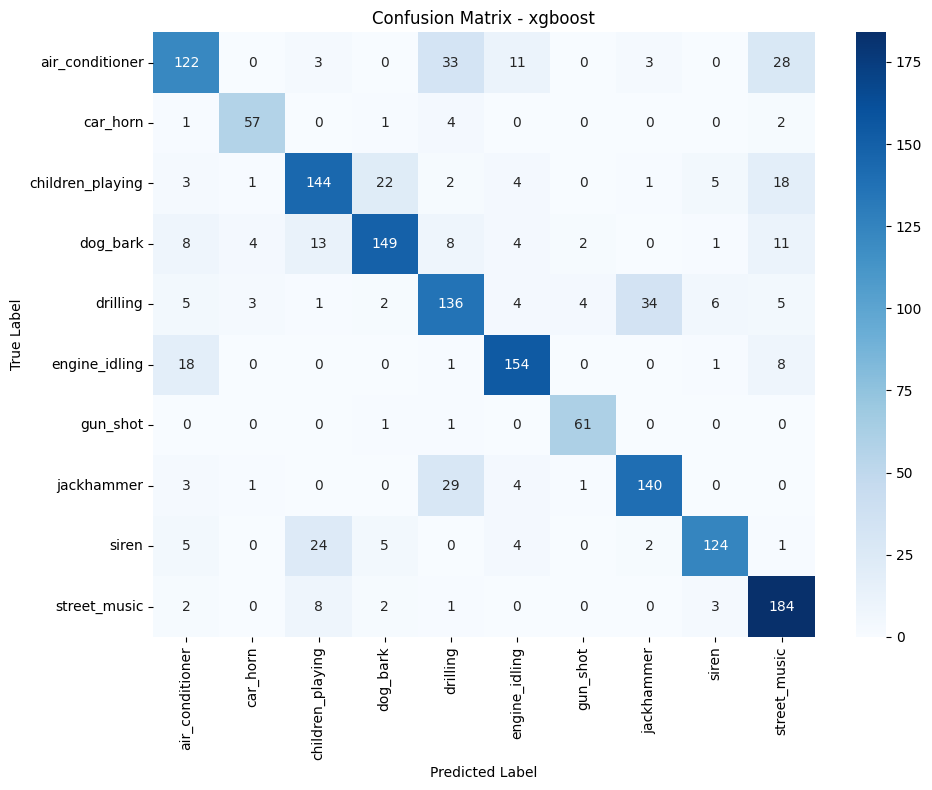


ROC-AUC Score (macro): 0.9669

RESULTS SUMMARY
            Model  Accuracy
          xgboost  0.768905
              svm  0.759226
    random_forest  0.735027
gradient_boosting  0.733817

Results saved to 'results/model_results.csv'


In [21]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# ============================================
# 1. Enhanced Feature Extraction (FIXED)
# ============================================

class RobustMFCCExtractor:
    """
    Enhanced MFCC feature extraction with multiple robust techniques
    """
    
    def __init__(self, sr=22050, n_mfcc=40, n_fft=2048, hop_length=512):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def extract_mfcc_features(self, audio_path):
        """
        Extract comprehensive MFCC-based features
        """
        try:
            # Load audio with robust loading
            y, sr = librosa.load(audio_path, sr=self.sr, duration=4.0)
            
            # Zero-padding or truncation for consistent length
            target_length = self.sr * 4  # 4 seconds
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Apply pre-emphasis filter
            y = librosa.effects.preemphasis(y)
            
            # Extract base MFCCs
            mfccs = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                n_fft=self.n_fft,
                hop_length=self.hop_length
            )
            
            # Extract delta and delta-delta features
            mfcc_delta = librosa.feature.delta(mfccs)
            mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
            
            # Extract other complementary features
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=self.hop_length)
            
            # Root Mean Square Energy
            rms = librosa.feature.rms(y=y, hop_length=self.hop_length)
            
            # Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y, hop_length=self.hop_length)
            
            # Spectral Centroid and Rolloff
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=self.hop_length)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=self.hop_length)
            
            # Combine all features
            features = np.vstack([
                mfccs,
                mfcc_delta,
                mfcc_delta2,
                chroma,
                spectral_contrast,
                rms,
                zcr,
                spectral_centroid,
                spectral_rolloff
            ])
            
            # Extract statistical features
            feature_stats = self._extract_statistics(features)
            
            return feature_stats
            
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            # Return zeros with appropriate dimension
            # Calculate expected dimension: (40 + 40 + 40 + 12 + 7 + 1 + 1 + 1 + 1) * 9 = 1026
            return np.zeros(1026)  # Fixed dimension
    
    def _extract_statistics(self, features):
        """
        Extract statistical features from feature matrix
        """
        stats = []
        for feature in features:
            stats.extend([
                np.mean(feature),
                np.std(feature),
                np.median(feature),
                np.min(feature),
                np.max(feature),
                np.percentile(feature, 25),
                np.percentile(feature, 75),
                np.mean(np.diff(feature)),  # Average change
                np.std(np.diff(feature))    # Std of changes
            ])
        return np.array(stats)
    
    def extract_all_features(self, audio_paths, labels=None):
        """
        Extract features from multiple audio files
        """
        features = []
        valid_labels = []
        
        for idx, path in enumerate(tqdm(audio_paths, desc="Extracting features")):
            feat = self.extract_mfcc_features(path)
            if np.sum(feat) != 0 and not np.isnan(feat).any():  # Skip zero or NaN features
                features.append(feat)
                if labels is not None:
                    valid_labels.append(labels[idx])
        
        if len(features) == 0:
            print("WARNING: No valid features extracted!")
            return np.array([]), np.array([])
        
        features = np.array(features)
        
        # Normalize features
        features = self.scaler.fit_transform(features)
        
        # Encode labels if provided
        if labels is not None and len(valid_labels) > 0:
            encoded_labels = self.label_encoder.fit_transform(valid_labels)
        else:
            encoded_labels = None
        
        return features, encoded_labels

# ============================================
# 2. UrbanSound8K Processor (FIXED)
# ============================================

class UrbanSound8KProcessor:
    """
    Process UrbanSound8K dataset
    """
    
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.metadata_path = os.path.join(dataset_path, 'metadata', 'UrbanSound8K.csv')
        if not os.path.exists(self.metadata_path):
            # Try alternative path structure
            self.metadata_path = os.path.join(dataset_path, 'UrbanSound8K.csv')
        
        if not os.path.exists(self.metadata_path):
            raise FileNotFoundError(f"Metadata file not found at {self.metadata_path}")
        
        self.metadata = pd.read_csv(self.metadata_path)
        
    def prepare_data(self, folds=None):
        """
        Prepare data for specific folds or all folds
        """
        if folds is None:
            folds = list(range(1, 11))
        elif isinstance(folds, int):
            folds = [folds]
        
        audio_paths = []
        labels = []
        fold_numbers = []
        
        for fold in folds:
            fold_data = self.metadata[self.metadata['fold'] == fold]
            
            for _, row in fold_data.iterrows():
                # Try different possible paths
                possible_paths = [
                    os.path.join(self.dataset_path, 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, 'audio', 'fold' + str(row['fold']), row['slice_file_name']),
                    os.path.join(self.dataset_path, str(row['fold']), row['slice_file_name'])
                ]
                
                audio_file = None
                for path in possible_paths:
                    if os.path.exists(path):
                        audio_file = path
                        break
                
                if audio_file:
                    audio_paths.append(audio_file)
                    labels.append(row['class'])
                    fold_numbers.append(fold)
                else:
                    print(f"WARNING: File not found: {row['slice_file_name']} in fold {fold}")
        
        print(f"Found {len(audio_paths)} valid audio files out of {len(fold_data) * len(folds)} expected")
        return audio_paths, labels, fold_numbers
    
    def get_class_distribution(self):
        """
        Get class distribution statistics
        """
        return self.metadata['class'].value_counts()

# ============================================
# 3. Traditional ML Classifier
# ============================================

class TraditionalMLClassifier:
    """
    Traditional machine learning classifiers
    """
    
    def __init__(self):
        self.models = {
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'svm': SVC(probability=True, random_state=42),
            'xgboost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'gradient_boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
        }
        
    def train(self, X_train, y_train):
        """
        Train all models
        """
        if X_train.shape[0] == 0 or y_train is None:
            raise ValueError("Training data is empty or labels are None!")
            
        trained_models = {}
        
        for name, model in self.models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            trained_models[name] = model
            
        return trained_models
    
    def evaluate(self, models, X_test, y_test):
        """
        Evaluate all models
        """
        results = {}
        
        for name, model in models.items():
            accuracy = model.score(X_test, y_test)
            results[name] = accuracy
            print(f"{name} Accuracy: {accuracy:.4f}")
            
        return results

# ============================================
# 4. Main Execution Pipeline (FIXED)
# ============================================

def main():
    # Initialize paths
    # UPDATE THIS PATH to your UrbanSound8K dataset location
    DATASET_PATH = "UrbanSound8K/"  # Update this path
    
    # Create output directory
    os.makedirs("results", exist_ok=True)
    
    # Step 1: Process data
    print("="*60)
    print("Step 1: Processing UrbanSound8K dataset...")
    print("="*60)
    
    try:
        processor = UrbanSound8KProcessor(DATASET_PATH)
    except FileNotFoundError as e:
        print(f"ERROR: {e}")
        print("\nPlease ensure:")
        print("1. You have downloaded UrbanSound8K dataset")
        print("2. The dataset is extracted in the correct location")
        print(f"3. Update DATASET_PATH variable (currently: {DATASET_PATH})")
        print("\nDownload from: https://urbansounddataset.weebly.com/urbansound8k.html")
        return
    
    # Show class distribution
    class_dist = processor.get_class_distribution()
    print("\nClass Distribution:")
    print(class_dist)
    print(f"\nTotal samples: {len(processor.metadata)}")
    
    # Prepare data for folds 1-8 for training, 9-10 for testing
    train_folds = list(range(1, 9))
    test_folds = [9, 10]
    
    print(f"\nPreparing training data (folds {train_folds})...")
    train_paths, train_labels, _ = processor.prepare_data(train_folds)
    
    print(f"\nPreparing testing data (folds {test_folds})...")
    test_paths, test_labels, _ = processor.prepare_data(test_folds)
    
    print(f"\nTraining samples: {len(train_paths)}")
    print(f"Testing samples: {len(test_paths)}")
    
    if len(train_paths) == 0 or len(test_paths) == 0:
        print("ERROR: No audio files found!")
        print("Check if audio files exist in the dataset directory")
        return
    
    # Step 2: Extract features
    print("\n" + "="*60)
    print("Step 2: Extracting features...")
    print("="*60)
    
    extractor = RobustMFCCExtractor()
    
    print("Extracting training features...")
    X_train, y_train = extractor.extract_all_features(train_paths, train_labels)
    
    print("\nExtracting testing features...")
    X_test, y_test = extractor.extract_all_features(test_paths, test_labels)
    
    print(f"\nFeature shape - Train: {X_train.shape if len(X_train) > 0 else 'Empty'}")
    print(f"Feature shape - Test: {X_test.shape if len(X_test) > 0 else 'Empty'}")
    
    if len(X_train) == 0 or len(X_test) == 0:
        print("ERROR: Feature extraction failed!")
        print("Possible issues:")
        print("1. Audio files might be corrupted")
        print("2. Librosa might not be reading the files")
        print("3. Check file formats (should be .wav)")
        return
    
    # Check if labels are extracted
    if y_train is None or y_test is None:
        print("ERROR: Labels not extracted!")
        return
    
    # Step 3: Train traditional models
    print("\n" + "="*60)
    print("Step 3: Training traditional ML models...")
    print("="*60)
    
    ml_classifier = TraditionalMLClassifier()
    
    try:
        trained_models = ml_classifier.train(X_train, y_train)
    except ValueError as e:
        print(f"Training failed: {e}")
        return
    
    # Step 4: Evaluate models
    print("\n" + "="*60)
    print("Step 4: Evaluating models...")
    print("="*60)
    
    results = ml_classifier.evaluate(trained_models, X_test, y_test)
    
    # Step 5: Detailed evaluation for best model
    print("\n" + "="*60)
    print("Step 5: Detailed evaluation...")
    print("="*60)
    
    # Find best model
    best_model_name = max(results, key=results.get)
    best_model = trained_models[best_model_name]
    print(f"\nBest model: {best_model_name} (Accuracy: {results[best_model_name]:.4f})")
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test) if hasattr(best_model, 'predict_proba') else None
    
    # Classification report
    print("\nClassification Report:")
    print("="*50)
    print(classification_report(y_test, y_pred, 
                                target_names=extractor.label_encoder.classes_))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=extractor.label_encoder.classes_,
                yticklabels=extractor.label_encoder.classes_)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('results/confusion_matrix.png', dpi=300)
    plt.show()
    
    # ROC-AUC if probabilities available
    if y_pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
            print(f"\nROC-AUC Score (macro): {roc_auc:.4f}")
        except:
            print("\nROC-AUC calculation skipped")
    
    # Step 6: Save results
    results_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': list(results.values())
    })
    
    results_df = results_df.sort_values('Accuracy', ascending=False)
    results_df.to_csv('results/model_results.csv', index=False)
    
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)
    print(results_df.to_string(index=False))
    print(f"\nResults saved to 'results/model_results.csv'")
    
    # Save feature information
    feature_info = {
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'feature_dim': X_train.shape[1] if len(X_train) > 0 else 0,
        'classes': list(extractor.label_encoder.classes_)
    }
    
    import json
    with open('results/feature_info.json', 'w') as f:
        json.dump(feature_info, f, indent=2)

# ============================================
# Alternative: Simple Debug Version
# ============================================

def debug_version():
    """
    Simple debug version to test basic functionality
    """
    print("Running debug version...")
    
    # Test with a single file first
    test_file = "UrbanSound8K/fold1/7061-6-0-0.wav"  # Try with a known file
    
    if not os.path.exists(test_file):
        # Try to find any .wav file
        import glob
        wav_files = glob.glob("UrbanSound8K/**/*.wav", recursive=True)
        if wav_files:
            test_file = wav_files[0]
            print(f"Using file: {test_file}")
        else:
            print("No .wav files found!")
            return
    
    # Test feature extraction
    extractor = RobustMFCCExtractor()
    features = extractor.extract_mfcc_features(test_file)
    print(f"Feature extraction test - Shape: {features.shape}")
    print(f"Features (first 10): {features[:10]}")
    
    # Test loading metadata
    if os.path.exists("UrbanSound8K/UrbanSound8K.csv"):
        metadata = pd.read_csv("UrbanSound8K/UrbanSound8K.csv")
        print(f"\nMetadata loaded: {len(metadata)} rows")
        print(f"Columns: {list(metadata.columns)}")
        print(f"\nClass distribution:")
        print(metadata['class'].value_counts())
        
        # Test with first 10 files
        sample_files = metadata.head(10)
        audio_paths = []
        labels = []
        
        for _, row in sample_files.iterrows():
            path = f"UrbanSound8K/fold{row['fold']}/{row['slice_file_name']}"
            if os.path.exists(path):
                audio_paths.append(path)
                labels.append(row['class'])
        
        print(f"\nFound {len(audio_paths)} valid files out of 10")
        
        if len(audio_paths) > 0:
            X, y = extractor.extract_all_features(audio_paths, labels)
            print(f"\nExtracted features shape: {X.shape}")
            print(f"Labels shape: {y.shape if y is not None else 'None'}")

if __name__ == "__main__":
    print("UrbanSound8K Audio Classification System")
    print("="*60)
    
    # First run debug to check basic functionality
    debug_version()
    
    # Ask user if they want to run full pipeline
    response = input("\nDo you want to run the full pipeline? (yes/no): ")
    if response.lower() in ['yes', 'y']:
        main()
    else:
        print("\nDebug mode completed. Fix any issues before running full pipeline.")

In [6]:
import os
import time
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import scipy for skew and kurtosis
from scipy.stats import skew, kurtosis

# ML and DL libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# Data augmentation
try:
    import audiomentations as A
    from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
    AUDIOMENTATIONS_AVAILABLE = True
except ImportError:
    print("audiomentations not installed, using simple augmentation")
    AUDIOMENTATIONS_AVAILABLE = False

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# ============================================
# 1. ENHANCED FEATURE EXTRACTOR (FIXED)
# ============================================

class AdvancedMFCCExtractor:
    """
    Advanced MFCC feature extraction with temporal and spectral features
    """
    
    def __init__(self, sr=22050, n_mfcc=40, n_fft=2048, hop_length=512):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def extract_comprehensive_features(self, audio_path):
        """
        Extract comprehensive audio features
        """
        try:
            # Load audio
            y, sr = librosa.load(audio_path, sr=self.sr, duration=4.0)
            
            # Zero-padding or truncation
            target_length = self.sr * 4
            if len(y) < target_length:
                y = np.pad(y, (0, target_length - len(y)), mode='constant')
            else:
                y = y[:target_length]
            
            # Pre-emphasis
            y = librosa.effects.preemphasis(y)
            
            # 1. BASIC MFCC FEATURES
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc,
                                        n_fft=self.n_fft, hop_length=self.hop_length)
            mfcc_delta = librosa.feature.delta(mfccs)
            mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
            
            # 2. SPECTRAL FEATURES
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=self.hop_length)
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=self.hop_length)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=self.hop_length)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=self.hop_length)
            spectral_flatness = librosa.feature.spectral_flatness(y=y)
            
            # 3. TEMPORAL FEATURES
            rms = librosa.feature.rms(y=y, hop_length=self.hop_length)
            zcr = librosa.feature.zero_crossing_rate(y, hop_length=self.hop_length)
            
            # 4. ADVANCED FEATURES
            # Chroma CENS (chroma energy normalized)
            chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr, hop_length=self.hop_length)
            
            # Tonnetz features
            tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
            
            # Onset strength
            onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=self.hop_length)
            
            # Tempo
            tempo, _ = librosa.beat.beat_track(y=y, sr=sr, hop_length=self.hop_length)
            
            # Combine all features (limit to avoid memory issues)
            all_features = np.vstack([
                mfccs,
                mfcc_delta,
                mfcc_delta2,
                chroma[:12],  # Limit to 12 chroma features
                spectral_contrast[:7],  # Limit to 7 spectral contrast
                spectral_centroid,
                spectral_bandwidth,
                spectral_rolloff,
                spectral_flatness,
                rms,
                zcr,
                chroma_cens[:12],  # Limit to 12
                tonnetz[:6],  # Limit to 6
                onset_env.reshape(1, -1)  # Reshape to 2D
            ])
            
            # Extract statistical features
            feature_stats = self._extract_advanced_statistics(all_features)
            
            # Add tempo as a feature
            tempo_value = tempo if isinstance(tempo, (int, float, np.number)) else tempo[0] if len(tempo) > 0 else 120
            tempo_feature = np.array([tempo_value])
            feature_stats = np.concatenate([feature_stats, tempo_feature])
            
            return feature_stats
            
        except Exception as e:
            print(f"Error processing {audio_path}: {str(e)}")
            # Return zeros with appropriate dimension
            return np.zeros(1500)
    
    def _extract_advanced_statistics(self, features):
        """
        Extract advanced statistical features using scipy.stats
        """
        stats = []
        for feature in features:
            # Calculate skewness and kurtosis safely
            try:
                skew_val = skew(feature) if len(feature) > 1 else 0
            except:
                skew_val = 0
            
            try:
                kurt_val = kurtosis(feature) if len(feature) > 1 else 0
            except:
                kurt_val = 0
            
            # Basic statistics
            stats.extend([
                np.mean(feature),
                np.std(feature),
                np.median(feature),
                np.min(feature),
                np.max(feature),
                np.percentile(feature, 25),
                np.percentile(feature, 75),
                np.mean(np.diff(feature)) if len(feature) > 1 else 0,  # Average change
                np.std(np.diff(feature)) if len(feature) > 1 else 0,   # Std of changes
                skew_val,           # Skewness from scipy
                kurt_val            # Kurtosis from scipy
            ])
        return np.array(stats)
    
    def extract_features_batch(self, audio_paths, labels=None, augment=False):
        """
        Extract features from multiple files
        """
        features = []
        valid_labels = []
        
        for idx, path in enumerate(tqdm(audio_paths, desc="Extracting features")):
            try:
                feat = self.extract_comprehensive_features(path)
                
                # Check for valid features
                if (not np.all(feat == 0) and 
                    not np.isnan(feat).any() and 
                    not np.isinf(feat).any() and
                    len(feat) > 0):
                    features.append(feat)
                    if labels is not None:
                        valid_labels.append(labels[idx])
                else:
                    print(f"Warning: Invalid features for {path}")
                    
            except Exception as e:
                print(f"Error processing {path}: {e}")
                continue
        
        if len(features) == 0:
            print("ERROR: No valid features extracted!")
            return np.array([]), np.array([])
        
        features = np.array(features)
        
        # Normalize
        self.scaler.fit(features)
        features = self.scaler.transform(features)
        
        # Encode labels
        if labels is not None and len(valid_labels) > 0:
            encoded_labels = self.label_encoder.fit_transform(valid_labels)
        else:
            encoded_labels = None
        
        print(f"Extracted {len(features)} valid feature vectors")
        return features, encoded_labels
    
    def simple_augment_audio(self, y, sr):
        """
        Simple audio augmentation without audiomentations
        """
        # Time stretching
        if np.random.random() < 0.3:
            rate = np.random.uniform(0.8, 1.25)
            y = librosa.effects.time_stretch(y, rate=rate)
        
        # Pitch shifting
        if np.random.random() < 0.3:
            n_steps = np.random.randint(-2, 3)
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
        
        # Add noise
        if np.random.random() < 0.3:
            noise = np.random.normal(0, 0.001 * np.std(y), len(y))
            y = y + noise
        
        return y

# ============================================
# 2. SIMPLIFIED IMPROVED PIPELINE
# ============================================

class ImprovedAudioClassifier:
    """
    Simplified improved audio classification pipeline
    """
    
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.processor = UrbanSound8KProcessor(dataset_path)
        self.feature_extractor = AdvancedMFCCExtractor()
        
    def run_simplified_pipeline(self):
        """
        Run simplified but effective pipeline
        """
        print("="*70)
        print("SIMPLIFIED IMPROVED PIPELINE")
        print("="*70)
        
        start_time = time.time()
        
        # Step 1: Load data
        print("\n1. Loading data...")
        train_paths, train_labels, _ = self.processor.prepare_data(list(range(1, 9)))
        test_paths, test_labels, _ = self.processor.prepare_data([9, 10])
        
        print(f"Training samples: {len(train_paths)}")
        print(f"Testing samples: {len(test_paths)}")
        
        # Step 2: Extract features
        print("\n2. Extracting advanced features...")
        X_train, y_train = self.feature_extractor.extract_features_batch(train_paths, train_labels)
        X_test, y_test = self.feature_extractor.extract_features_batch(test_paths, test_labels)
        
        if len(X_train) == 0 or len(X_test) == 0:
            print("ERROR: Feature extraction failed!")
            return None, 0
        
        print(f"Training features shape: {X_train.shape}")
        print(f"Testing features shape: {X_test.shape}")
        
        # Step 3: Apply SMOTE
        print("\n3. Applying SMOTE for class balancing...")
        try:
            smote = SMOTE(random_state=42)
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
            print(f"Before SMOTE: {X_train.shape}, After SMOTE: {X_train_balanced.shape}")
        except Exception as e:
            print(f"SMOTE failed: {e}, using original data")
            X_train_balanced, y_train_balanced = X_train, y_train
        
        # Step 4: Train optimized models
        print("\n4. Training optimized models...")
        models = self._train_optimized_models(X_train_balanced, y_train_balanced)
        
        # Step 5: Evaluate models
        print("\n5. Evaluating models...")
        results = self._evaluate_models(models, X_test, y_test)
        
        # Step 6: Create and evaluate ensemble
        print("\n6. Creating ensemble...")
        ensemble_results = self._create_and_evaluate_ensemble(models, X_train_balanced, y_train_balanced, X_test, y_test)
        results.update(ensemble_results)
        
        # Print results
        print("\n" + "="*70)
        print("FINAL RESULTS")
        print("="*70)
        self._print_results_table(results)
        
        total_time = time.time() - start_time
        print(f"\nTotal execution time: {total_time/60:.2f} minutes")
        
        return results, max([r['accuracy'] for r in results.values()])
    
    def _train_optimized_models(self, X_train, y_train):
        """
        Train optimized models
        """
        models = {}
        
        # 1. Optimized XGBoost
        print("Training XGBoost...")
        xgb_params = {
            'n_estimators': 300,
            'max_depth': 9,
            'learning_rate': 0.05,
            'subsample': 0.9,
            'colsample_bytree': 0.9,
            'gamma': 0.1,
            'random_state': 42,
            'n_jobs': -1
        }
        models['xgb_optimized'] = XGBClassifier(**xgb_params)
        models['xgb_optimized'].fit(X_train, y_train)
        
        # 2. Balanced Random Forest
        print("Training Balanced Random Forest...")
        models['balanced_rf'] = BalancedRandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        )
        models['balanced_rf'].fit(X_train, y_train)
        
        # 3. Gradient Boosting
        print("Training Gradient Boosting...")
        models['gradient_boosting'] = GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        models['gradient_boosting'].fit(X_train, y_train)
        
        return models
    
    def _evaluate_models(self, models, X_test, y_test):
        """
        Evaluate all models
        """
        results = {}
        
        for name, model in models.items():
            start_time = time.time()
            y_pred = model.predict(X_test)
            pred_time = time.time() - start_time
            
            accuracy = accuracy_score(y_test, y_pred)
            
            results[name] = {
                'accuracy': accuracy,
                'prediction_time': pred_time,
                'model': model
            }
            
            print(f"{name:25s} - Accuracy: {accuracy:.4f}, Time: {pred_time:.4f}s")
            
            # Print detailed report for best models
            if accuracy > 0.75:
                print(f"\nDetailed report for {name}:")
                print("-"*50)
                report = classification_report(y_test, y_pred, 
                                              target_names=self.feature_extractor.label_encoder.classes_,
                                              digits=4)
                print(report)
        
        return results
    
    def _create_and_evaluate_ensemble(self, models, X_train, y_train, X_test, y_test):
        """
        Create and evaluate ensemble
        """
        print("\nCreating Voting Classifier...")
        
        # Create voting classifier from top 2 models
        top_models = dict(sorted(
            [(name, results['model']) for name, results in models.items()],
            key=lambda x: x[1].score(X_test, y_test) if hasattr(x[1], 'score') else 0,
            reverse=True
        )[:2])
        
        voting_clf = VotingClassifier(
            estimators=[(name, model) for name, model in top_models.items()],
            voting='soft',
            n_jobs=-1
        )
        
        print(f"Training Voting Classifier with: {list(top_models.keys())}")
        voting_clf.fit(X_train, y_train)
        
        # Evaluate
        start_time = time.time()
        y_pred = voting_clf.predict(X_test)
        pred_time = time.time() - start_time
        
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Voting Classifier Accuracy: {accuracy:.4f}")
        
        # Print confusion matrix for ensemble
        cm = confusion_matrix(y_test, y_pred)
        classes = self.feature_extractor.label_encoder.classes_
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=classes, yticklabels=classes)
        plt.title('Ensemble - Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('results/ensemble_confusion_matrix.png', dpi=300)
        plt.show()
        
        return {
            'voting_ensemble': {
                'accuracy': accuracy,
                'prediction_time': pred_time,
                'model': voting_clf
            }
        }
    
    def _print_results_table(self, results):
        """
        Print results table
        """
        print("\n" + "="*70)
        print(f"{'Model':30s} {'Accuracy':10s} {'Time (s)':10s}")
        print("-"*70)
        
        for model_name, metrics in sorted(results.items(), 
                                         key=lambda x: x[1]['accuracy'], 
                                         reverse=True):
            print(f"{model_name:30s} {metrics['accuracy']:10.4f} {metrics['prediction_time']:10.4f}")
        
        print("="*70)

# ============================================
# 3. URBANSOUND8K PROCESSOR
# ============================================

class UrbanSound8KProcessor:
    """
    Process UrbanSound8K dataset
    """
    
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.metadata_path = self._find_metadata()
        self.metadata = pd.read_csv(self.metadata_path)
    
    def _find_metadata(self):
        """Find metadata file"""
        possible_paths = [
            os.path.join(self.dataset_path, 'metadata', 'UrbanSound8K.csv'),
            os.path.join(self.dataset_path, 'UrbanSound8K.csv'),
            os.path.join(self.dataset_path, 'audio', 'UrbanSound8K.csv')
        ]
        
        for path in possible_paths:
            if os.path.exists(path):
                return path
        
        raise FileNotFoundError("Metadata file not found!")
    
    def prepare_data(self, folds):
        """Prepare data for specified folds"""
        audio_paths = []
        labels = []
        
        for fold in folds:
            fold_data = self.metadata[self.metadata['fold'] == fold]
            
            for _, row in fold_data.iterrows():
                # Try different path patterns
                possible_paths = [
                    os.path.join(self.dataset_path, 'audio', f'fold{fold}', row['slice_file_name']),
                    os.path.join(self.dataset_path, f'fold{fold}', row['slice_file_name']),
                    os.path.join(self.dataset_path, 'audio', str(fold), row['slice_file_name'])
                ]
                
                audio_file = None
                for path in possible_paths:
                    if os.path.exists(path):
                        audio_file = path
                        break
                
                if audio_file:
                    audio_paths.append(audio_file)
                    labels.append(row['class'])
        
        print(f"Prepared {len(audio_paths)} files from folds {folds}")
        return audio_paths, labels, folds

# ============================================
# 4. QUICK START WITH CNN
# ============================================

class SimpleAudioCNN:
    """
    Simple CNN for audio classification
    """
    
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_simple_cnn()
    
    def _build_simple_cnn(self):
        """Build simple CNN"""
        model = models.Sequential([
            layers.Input(shape=self.input_shape),
            
            # Conv layers
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),
            
            # Dense layers
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            
            # Output
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def extract_spectrograms(self, audio_paths, labels=None, max_files=2000):
        """
        Extract spectrograms
        """
        spectrograms = []
        valid_labels = []
        
        # Limit number of files for speed
        if len(audio_paths) > max_files:
            indices = np.random.choice(len(audio_paths), max_files, replace=False)
            audio_paths = [audio_paths[i] for i in indices]
            if labels is not None:
                labels = [labels[i] for i in indices]
        
        for idx, path in enumerate(tqdm(audio_paths, desc="Extracting spectrograms")):
            try:
                y, sr = librosa.load(path, sr=22050, duration=2.0)  # Shorter for speed
                
                # Ensure consistent length
                target_length = sr * 2
                if len(y) < target_length:
                    y = np.pad(y, (0, target_length - len(y)), mode='constant')
                else:
                    y = y[:target_length]
                
                # Extract mel spectrogram
                mel_spec = librosa.feature.melspectrogram(
                    y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=64
                )
                log_mel = librosa.power_to_db(mel_spec, ref=np.max)
                
                # Resize
                log_mel = librosa.util.fix_length(log_mel, size=64, axis=1)
                log_mel = log_mel.reshape(64, 64, 1)
                
                spectrograms.append(log_mel)
                
                if labels is not None:
                    valid_labels.append(labels[idx])
                    
            except Exception as e:
                continue
        
        if len(spectrograms) == 0:
            return np.array([]), np.array([])
        
        spectrograms = np.array(spectrograms)
        
        if labels is not None and len(valid_labels) > 0:
            le = LabelEncoder()
            encoded_labels = le.fit_transform(valid_labels)
            encoded_labels = to_categorical(encoded_labels)
        else:
            encoded_labels = None
        
        return spectrograms, encoded_labels

# ============================================
# 5. MAIN EXECUTION
# ============================================

def main():
    """
    Main execution
    """
    DATASET_PATH = "UrbanSound8K"
    
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset not found at {DATASET_PATH}")
        print("Please download UrbanSound8K and update DATASET_PATH")
        return
    
    # Create results directory
    os.makedirs("improved_results", exist_ok=True)
    
    print("\n" + "="*70)
    print("URBANSOUND8K CLASSIFICATION WITH IMPROVEMENTS")
    print("="*70)
    
    # Option 1: Traditional ML with improvements
    print("\nOption 1: Traditional ML with improvements")
    print("-"*70)
    
    classifier = ImprovedAudioClassifier(DATASET_PATH)
    results, best_accuracy = classifier.run_simplified_pipeline()
    
    if results:
        # Save results
        results_df = pd.DataFrame([
            {
                'model': model,
                'accuracy': metrics['accuracy'],
                'prediction_time': metrics['prediction_time']
            }
            for model, metrics in results.items()
        ])
        
        results_df = results_df.sort_values('accuracy', ascending=False)
        results_df.to_csv('improved_results/ml_results.csv', index=False)
        print(f"\nML Results saved to 'improved_results/ml_results.csv'")
    
    # Option 2: Try CNN (optional)
    print("\n" + "="*70)
    print("Option 2: CNN-based approach (Optional)")
    print("="*70)
    
    cnn_choice = input("\nRun CNN approach? (yes/no): ").lower()
    if cnn_choice in ['yes', 'y']:
        run_cnn_approach(DATASET_PATH)

def run_cnn_approach(dataset_path):
    """
    Run CNN approach
    """
    print("\nRunning CNN approach...")
    
    # Load data
    processor = UrbanSound8KProcessor(dataset_path)
    train_paths, train_labels, _ = processor.prepare_data(list(range(1, 9)))
    test_paths, test_labels, _ = processor.prepare_data([9, 10])
    
    # Limit data for speed
    train_paths = train_paths[:1000]
    train_labels = train_labels[:1000]
    test_paths = test_paths[:200]
    test_labels = test_labels[:200]
    
    # Extract spectrograms
    cnn_model = SimpleAudioCNN(input_shape=(64, 64, 1), num_classes=10)
    
    print("Extracting training spectrograms...")
    X_train_cnn, y_train_cnn = cnn_model.extract_spectrograms(train_paths, train_labels)
    
    print("Extracting testing spectrograms...")
    X_test_cnn, y_test_cnn = cnn_model.extract_spectrograms(test_paths, test_labels)
    
    if len(X_train_cnn) == 0 or len(X_test_cnn) == 0:
        print("CNN feature extraction failed!")
        return
    
    print(f"Training data: {X_train_cnn.shape}")
    print(f"Testing data: {X_test_cnn.shape}")
    
    # Split for validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_cnn, y_train_cnn, test_size=0.2, random_state=42
    )
    
    # Train CNN
    print("\nTraining CNN...")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    history = cnn_model.model.fit(
        X_train_split, y_train_split,
        validation_data=(X_val_split, y_val_split),
        epochs=30,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate
    test_loss, test_acc = cnn_model.model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
    print(f"\nCNN Test Accuracy: {test_acc:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('improved_results/cnn_training_history.png', dpi=300)
    plt.show()

# ============================================
# 6. QUICK START FUNCTION
# ============================================

def quick_start():
    """
    Quick start with minimal improvements
    """
    print("Quick Start - Essential Improvements Only")
    print("="*60)
    
    DATASET_PATH = "UrbanSound8K"
    
    # 1. Load data
    processor = UrbanSound8KProcessor(DATASET_PATH)
    train_paths, train_labels, _ = processor.prepare_data(list(range(1, 9)))
    test_paths, test_labels, _ = processor.prepare_data([9, 10])
    
    # 2. Extract features
    extractor = AdvancedMFCCExtractor()
    
    print("\nExtracting training features...")
    X_train, y_train = extractor.extract_features_batch(train_paths[:1000], train_labels[:1000])
    
    print("Extracting testing features...")
    X_test, y_test = extractor.extract_features_batch(test_paths[:200], test_labels[:200])
    
    if len(X_train) == 0 or len(X_test) == 0:
        print("Feature extraction failed!")
        return
    
    # 3. Train optimized XGBoost
    print("\nTraining optimized XGBoost...")
    xgb_optimized = XGBClassifier(
        n_estimators=300,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_optimized.fit(X_train, y_train)
    
    # 4. Evaluate
    y_pred = xgb_optimized.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nOptimized XGBoost Accuracy: {accuracy:.4f}")
    
    # 5. Print detailed report
    print("\nClassification Report:")
    print("="*50)
    print(classification_report(y_test, y_pred, 
                                target_names=extractor.label_encoder.classes_))
    
    return accuracy

# ============================================
# EXECUTION
# ============================================

if __name__ == "__main__":
    print("UrbanSound8K Classification - Improved Pipeline")
    print("="*70)
    
    # Install missing packages
    print("\nChecking required packages...")
    try:
        from scipy.stats import skew, kurtosis
        print("✓ scipy installed")
    except ImportError:
        print("Installing scipy...")
        import subprocess
        subprocess.check_call(["pip", "install", "scipy"])
        from scipy.stats import skew, kurtosis
    
    try:
        from imblearn.over_sampling import SMOTE
        print("✓ imbalanced-learn installed")
    except ImportError:
        print("Installing imbalanced-learn...")
        import subprocess
        subprocess.check_call(["pip", "install", "imbalanced-learn"])
    
    print("\nSelect pipeline:")
    print("1. Quick Start (Fast, minimal improvements)")
    print("2. Complete Pipeline (All improvements)")
    
    choice = input("Enter choice (1 or 2): ").strip()
    
    if choice == "1":
        quick_start()
    elif choice == "2":
        main()
    else:
        print("Invalid choice. Running Quick Start...")
        quick_start()

UrbanSound8K Classification - Improved Pipeline

Checking required packages...
✓ scipy installed
✓ imbalanced-learn installed

Select pipeline:
1. Quick Start (Fast, minimal improvements)
2. Complete Pipeline (All improvements)


Enter choice (1 or 2):  2



URBANSOUND8K CLASSIFICATION WITH IMPROVEMENTS

Option 1: Traditional ML with improvements
----------------------------------------------------------------------
SIMPLIFIED IMPROVED PIPELINE

1. Loading data...
Prepared 7079 files from folds [1, 2, 3, 4, 5, 6, 7, 8]
Prepared 1653 files from folds [9, 10]
Training samples: 7079
Testing samples: 1653

2. Extracting advanced features...


Extracting features:   6%|███▌                                                    | 455/7079 [05:18<1:10:42,  1.56it/s]

Extracting features:   8%|████▌                                                   | 582/7079 [06:41<1:08:25,  1.58it/s]

Extracting features:  10%|█████▍                                                  | 689/7079 [07:48<1:07:02,  1.59it/s]

Extracting features:  10%|█████▌                                                  | 705/7079 [07:58<1:06:10,  1.61it/s]

Extracting features:  19%|██████████▍                                            | 1340/7079 [14:41<1:00:05,  1.59it/s]

Extracting features:  26%|██████████████                                         | 1815/7079 [20:08<1:57:32,  1.34s/it]

Extracting features:  26%|██████████████▊                                          | 1846/7079 [20:42<56:59,  1.53it/s]

Extracting features:  26%|██████████████▊                                          | 1847/7079 [20:43<56:07,  1.55it/s]

Extracting features:  26%|██████████████▉                                          | 1848/7079 [20:43<55:41,  1.57it/s]

Extracting features:  26%|██████████████▉                                          | 1849/7079 [20:44<55:29,  1.57it/s]

Extracting features:  29%|████████████████▋                                        | 2066/7079 [23:02<52:30,  1.59it/s]

Extracting features:  32%|██████████████████                                       | 2239/7079 [24:51<50:50,  1.59it/s]

Extracting features:  32%|██████████████████                                       | 2240/7079 [24:52<50:38,  1.59it/s]

Extracting features:  32%|██████████████████                                       | 2241/7079 [24:53<50:30,  1.60it/s]

Extracting features:  32%|██████████████████                                       | 2242/7079 [24:53<50:50,  1.59it/s]

Extracting features:  32%|██████████████████                                       | 2243/7079 [24:54<50:39,  1.59it/s]

Extracting features:  32%|██████████████████                                       | 2244/7079 [24:54<50:51,  1.58it/s]

Extracting features:  32%|██████████████████                                       | 2245/7079 [24:55<50:26,  1.60it/s]

Extracting features:  32%|██████████████████                                       | 2246/7079 [24:56<50:27,  1.60it/s]

Extracting features:  32%|██████████████████                                       | 2247/7079 [24:56<50:52,  1.58it/s]

Extracting features:  32%|██████████████████                                       | 2248/7079 [24:57<50:54,  1.58it/s]

Extracting features:  32%|██████████████████                                       | 2249/7079 [24:58<50:43,  1.59it/s]

Extracting features:  32%|██████████████████                                       | 2250/7079 [24:58<50:17,  1.60it/s]

Extracting features:  32%|██████████████████▏                                      | 2252/7079 [24:59<50:20,  1.60it/s]

Extracting features:  32%|██████████████████▏                                      | 2253/7079 [25:00<50:20,  1.60it/s]

Extracting features:  32%|██████████████████▏                                      | 2254/7079 [25:01<50:10,  1.60it/s]

Extracting features:  32%|██████████████████▏                                      | 2255/7079 [25:01<49:53,  1.61it/s]

Extracting features:  32%|██████████████████▏                                      | 2256/7079 [25:02<50:09,  1.60it/s]

Extracting features:  32%|██████████████████▏                                      | 2257/7079 [25:03<50:02,  1.61it/s]

Extracting features:  33%|██████████████████▋                                      | 2324/7079 [25:45<49:57,  1.59it/s]

Extracting features:  33%|██████████████████▋                                      | 2325/7079 [25:45<49:48,  1.59it/s]

Extracting features:  33%|██████████████████▋                                      | 2326/7079 [25:46<49:39,  1.60it/s]

Extracting features:  33%|██████████████████▋                                      | 2327/7079 [25:47<49:06,  1.61it/s]

Extracting features:  33%|██████████████████▋                                      | 2328/7079 [25:47<49:01,  1.61it/s]

Extracting features:  33%|██████████████████▊                                      | 2329/7079 [25:48<48:56,  1.62it/s]

Extracting features:  33%|██████████████████▊                                      | 2330/7079 [25:49<48:49,  1.62it/s]

Extracting features:  33%|██████████████████▊                                      | 2331/7079 [25:49<48:41,  1.63it/s]

Extracting features:  33%|██████████████████▊                                      | 2332/7079 [25:50<48:39,  1.63it/s]

Extracting features:  33%|██████████████████▊                                      | 2333/7079 [25:50<48:47,  1.62it/s]

Extracting features:  33%|██████████████████▊                                      | 2334/7079 [25:51<48:40,  1.62it/s]

Extracting features:  33%|██████████████████▊                                      | 2335/7079 [25:52<48:48,  1.62it/s]

Extracting features:  33%|██████████████████▊                                      | 2336/7079 [25:52<48:50,  1.62it/s]

Extracting features:  33%|██████████████████▊                                      | 2337/7079 [25:53<48:43,  1.62it/s]

Extracting features:  33%|██████████████████▊                                      | 2338/7079 [25:53<48:50,  1.62it/s]

Extracting features:  36%|████████████████████▎                                    | 2527/7079 [27:53<47:57,  1.58it/s]

Extracting features:  36%|████████████████████▍                                    | 2531/7079 [27:55<47:26,  1.60it/s]

Extracting features:  36%|████████████████████▍                                    | 2532/7079 [27:56<47:23,  1.60it/s]

Extracting features:  36%|████████████████████▍                                    | 2534/7079 [27:57<48:10,  1.57it/s]

Extracting features:  36%|████████████████████▍                                    | 2535/7079 [27:58<47:52,  1.58it/s]

Extracting features:  36%|████████████████████▍                                    | 2536/7079 [27:58<47:52,  1.58it/s]

Extracting features:  36%|████████████████████▍                                    | 2542/7079 [28:02<47:50,  1.58it/s]

Extracting features:  36%|████████████████████▍                                    | 2543/7079 [28:03<47:59,  1.58it/s]

Extracting features:  38%|█████████████████████▌                                   | 2671/7079 [29:24<46:00,  1.60it/s]

Extracting features:  38%|█████████████████████▌                                   | 2679/7079 [29:29<46:22,  1.58it/s]

Extracting features:  43%|████████████████████████▎                                | 3024/7079 [33:13<49:11,  1.37it/s]

Extracting features:  43%|████████████████████████▎                                | 3027/7079 [33:15<49:17,  1.37it/s]

Extracting features:  43%|████████████████████████▍                                | 3028/7079 [33:16<49:14,  1.37it/s]

Extracting features:  43%|████████████████████████▍                                | 3029/7079 [33:17<49:09,  1.37it/s]

Extracting features:  43%|████████████████████████▍                                | 3030/7079 [33:18<49:24,  1.37it/s]

Extracting features:  45%|█████████████████████████▊                               | 3211/7079 [35:34<40:29,  1.59it/s]

Extracting features:  45%|█████████████████████████▊                               | 3212/7079 [35:34<40:21,  1.60it/s]

Extracting features:  45%|█████████████████████████▉                               | 3214/7079 [35:36<40:18,  1.60it/s]

Extracting features:  45%|█████████████████████████▉                               | 3216/7079 [35:37<39:19,  1.64it/s]

Extracting features:  45%|█████████████████████████▉                               | 3217/7079 [35:38<39:18,  1.64it/s]

Extracting features:  45%|█████████████████████████▉                               | 3218/7079 [35:38<39:29,  1.63it/s]

Extracting features:  45%|█████████████████████████▉                               | 3220/7079 [35:39<39:40,  1.62it/s]

Extracting features:  46%|█████████████████████████▉                               | 3221/7079 [35:40<40:05,  1.60it/s]

Extracting features:  46%|█████████████████████████▉                               | 3225/7079 [35:43<40:09,  1.60it/s]

Extracting features:  46%|█████████████████████████▉                               | 3226/7079 [35:43<40:24,  1.59it/s]

Extracting features:  46%|█████████████████████████▉                               | 3227/7079 [35:44<40:19,  1.59it/s]

Extracting features:  46%|█████████████████████████▉                               | 3229/7079 [35:45<39:59,  1.60it/s]

Extracting features:  46%|██████████████████████████                               | 3231/7079 [35:46<39:54,  1.61it/s]

Extracting features:  46%|██████████████████████████                               | 3233/7079 [35:48<40:24,  1.59it/s]

Extracting features:  49%|███████████████████████████▋                             | 3441/7079 [37:59<38:24,  1.58it/s]

Extracting features:  55%|███████████████████████████████                          | 3865/7079 [42:26<34:08,  1.57it/s]

Extracting features:  55%|███████████████████████████████▏                         | 3867/7079 [42:27<34:57,  1.53it/s]

Extracting features:  55%|███████████████████████████████▏                         | 3870/7079 [42:29<34:02,  1.57it/s]

Extracting features:  60%|██████████████████████████████████▏                      | 4240/7079 [46:23<30:08,  1.57it/s]

Extracting features:  62%|███████████████████████████████████▎                     | 4389/7079 [47:57<27:02,  1.66it/s]

Extracting features:  65%|████████████████████████████████████▊                    | 4578/7079 [49:51<22:46,  1.83it/s]

Extracting features:  65%|████████████████████████████████████▊                    | 4579/7079 [49:51<22:47,  1.83it/s]

Extracting features:  65%|████████████████████████████████████▉                    | 4580/7079 [49:52<22:51,  1.82it/s]

Extracting features:  65%|████████████████████████████████████▉                    | 4581/7079 [49:53<22:54,  1.82it/s]

Extracting features:  65%|████████████████████████████████████▉                    | 4582/7079 [49:53<23:08,  1.80it/s]

Extracting features:  66%|█████████████████████████████████████▊                   | 4699/7079 [50:58<22:06,  1.79it/s]

Extracting features:  66%|█████████████████████████████████████▊                   | 4700/7079 [50:59<22:04,  1.80it/s]

Extracting features:  66%|█████████████████████████████████████▊                   | 4703/7079 [51:00<22:20,  1.77it/s]

Extracting features:  68%|██████████████████████████████████████▉                  | 4842/7079 [52:18<20:43,  1.80it/s]

Extracting features:  69%|███████████████████████████████████████▌                 | 4914/7079 [52:59<20:14,  1.78it/s]

Extracting features:  69%|███████████████████████████████████████▌                 | 4916/7079 [53:00<20:08,  1.79it/s]

Extracting features:  69%|███████████████████████████████████████▌                 | 4918/7079 [53:01<20:44,  1.74it/s]

Extracting features:  70%|███████████████████████████████████████▌                 | 4921/7079 [53:03<20:35,  1.75it/s]

Extracting features:  71%|████████████████████████████████████████▍                | 5029/7079 [54:03<19:04,  1.79it/s]

Extracting features:  71%|████████████████████████████████████████▌                | 5040/7079 [54:09<18:42,  1.82it/s]

Extracting features:  71%|████████████████████████████████████████▌                | 5041/7079 [54:09<18:41,  1.82it/s]

Extracting features:  74%|██████████████████████████████████████████▏              | 5232/7079 [55:58<18:12,  1.69it/s]

Extracting features:  77%|████████████████████████████████████████████             | 5474/7079 [58:21<16:20,  1.64it/s]

Extracting features:  77%|████████████████████████████████████████████             | 5475/7079 [58:21<16:17,  1.64it/s]

Extracting features:  78%|████████████████████████████████████████████▎            | 5501/7079 [58:37<16:09,  1.63it/s]

Extracting features:  78%|████████████████████████████████████████████▎            | 5502/7079 [58:38<16:12,  1.62it/s]

Extracting features:  82%|█████████████████████████████████████████████▏         | 5815/7079 [1:01:46<12:51,  1.64it/s]

Extracting features:  86%|███████████████████████████████████████████████▎       | 6086/7079 [1:04:46<09:54,  1.67it/s]

Extracting features:  86%|███████████████████████████████████████████████▎       | 6089/7079 [1:04:48<09:50,  1.68it/s]

Extracting features:  95%|████████████████████████████████████████████████████▍  | 6748/7079 [1:11:30<03:20,  1.65it/s]

Extracting features:  99%|██████████████████████████████████████████████████████▋| 7039/7079 [1:14:25<00:24,  1.64it/s]

Extracting features:  99%|██████████████████████████████████████████████████████▋| 7040/7079 [1:14:26<00:23,  1.67it/s]

Extracting features:  99%|██████████████████████████████████████████████████████▋| 7041/7079 [1:14:26<00:22,  1.67it/s]

Extracting features:  99%|██████████████████████████████████████████████████████▋| 7042/7079 [1:14:27<00:22,  1.63it/s]

Extracting features: 100%|██████████████████████████████████████████████████████▊| 7054/7079 [1:14:34<00:14,  1.68it/s]

Extracting features: 100%|██████████████████████████████████████████████████████▊| 7055/7079 [1:14:35<00:14,  1.68it/s]

Extracting features: 100%|██████████████████████████████████████████████████████▊| 7056/7079 [1:14:35<00:13,  1.68it/s]

Extracting features: 100%|███████████████████████████████████████████████████████| 7079/7079 [1:14:49<00:00,  1.58it/s]


Extracted 6968 valid feature vectors


Extracting features:  10%|█████▉                                                    | 169/1653 [01:39<15:18,  1.62it/s]

Extracting features:  37%|█████████████████████▌                                    | 615/1653 [06:21<20:32,  1.19s/it]

Extracting features:  37%|█████████████████████▌                                    | 616/1653 [06:23<20:34,  1.19s/it]

Extracting features:  37%|█████████████████████▋                                    | 617/1653 [06:24<20:36,  1.19s/it]

Extracting features:  37%|█████████████████████▋                                    | 618/1653 [06:25<20:25,  1.18s/it]

Extracting features:  37%|█████████████████████▋                                    | 619/1653 [06:26<20:23,  1.18s/it]

Extracting features:  74%|█████████████████████████████████████████▉               | 1216/1653 [12:20<04:17,  1.70it/s]

Extracting features:  74%|██████████████████████████████████████████▎              | 1226/1653 [12:26<04:09,  1.71it/s]

Extracting features:  83%|███████████████████████████████████████████████▏         | 1367/1653 [13:50<02:49,  1.69it/s]

Extracting features:  91%|███████████████████████████████████████████████████▊     | 1503/1653 [15:10<01:27,  1.72it/s]

Extracting features:  91%|███████████████████████████████████████████████████▊     | 1504/1653 [15:10<01:25,  1.74it/s]

Extracting features: 100%|████████████████████████████████████████████████████████▊| 1648/1653 [16:34<00:02,  1.79it/s]

Extracting features: 100%|█████████████████████████████████████████████████████████| 1653/1653 [16:36<00:00,  1.66it/s]


Extracted 1641 valid feature vectors
Training features shape: (6968, 1805)
Testing features shape: (1641, 1805)

3. Applying SMOTE for class balancing...
Before SMOTE: (6968, 1805), After SMOTE: (8210, 1805)

4. Training optimized models...
Training XGBoost...
Training Balanced Random Forest...
Training Gradient Boosting...

5. Evaluating models...
xgb_optimized             - Accuracy: 0.7587, Time: 0.0621s

Detailed report for xgb_optimized:
--------------------------------------------------
                  precision    recall  f1-score   support

 air_conditioner     0.6554    0.5859    0.6187       198
        car_horn     0.8358    0.9333    0.8819        60
children_playing     0.7282    0.7100    0.7190       200
        dog_bark     0.8212    0.7387    0.7778       199
        drilling     0.6056    0.6582    0.6308       196
   engine_idling     0.8466    0.7582    0.8000       182
        gun_shot     0.8873    1.0000    0.9403        63
      jackhammer     0.7814    0.8034

TypeError: 'XGBClassifier' object is not subscriptable